# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

План исследования:  
1. Загрузитm и подготовить данные.
2. Обучить и проверить модель для каждого региона:
 - Разбить данные на обучающую и валидационную выборки в соотношении 75:25
 - Обучить модель и сделайть предсказания на валидационной выборке
 - Сохранить предсказания и правильные ответы на валидационной выборке
 - Рассчитать средний запас предсказанного сырья и RMSE модели
3. Подготовка к расчёту прибыли:
 - Сохранить в отдельных переменных ключевые значения для расчётов
 - Рассчитать достаточный объём сырья для безубыточной разработки новой скважины. 
 - Сравнить полученный объём сырья со средним запасом в каждом регионе. 
 - Выводы по этапу подготовки расчёта прибыли.
4. Рассчитать прибыли и риски
5. Общий вывод

## Загрузка и подготовка данных

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MaxAbsScaler

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse, r2_score
from scipy import stats as st


In [64]:
try:
    data_0 = pd.read_csv('geo_data_0.csv')
    data_1 = pd.read_csv('geo_data_1.csv')
    data_2 = pd.read_csv('geo_data_2.csv')
except:
    data_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
    data_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
    data_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')


Просмотр и предобработка данных(при необходимости)

In [65]:
print(data_0.head(3))
print(data_1.head(3))
print(data_2.head(3))

      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
      id         f0        f1        f2     product
0  kBEdx -15.001348 -8.276000 -0.005876    3.179103
1  62mP7  14.272088 -3.475083  0.999183   26.953261
2  vyE1P   6.263187 -5.948386  5.001160  134.766305
      id        f0        f1        f2    product
0  fwXo0 -1.146987  0.963328 -0.828965  27.758673
1  WJtFt  0.262778  0.269839 -2.530187  56.069697
2  ovLUW  0.194587  0.289035 -5.586433  62.871910


In [66]:
print(f'{data_0.shape}, {data_1.shape}, {data_2.shape}')

(100000, 5), (100000, 5), (100000, 5)


In [67]:
data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [68]:
col_list_0 = data_0.columns
col_list_1 = data_1.columns
col_list_2 = data_2.columns

col_list_0


Index(['id', 'f0', 'f1', 'f2', 'product'], dtype='object')

In [69]:
print('кол-во дупликатов в data_1:', data_0.duplicated().sum())
for col in col_list_0:
    print('-' * 25)
    print(col, ': кол-во NaN', data_0[col].isna().sum(), ', процент NaN',
          round(data_0[col].isna().sum() / len(data_0) * 100, 2), '%')
print('=' * 50)
print()


print('кол-во дупликатов в data_1:', data_1.duplicated().sum())
for col in col_list_1:
    print('-' * 25)
    print(col, ': кол-во NaN', data_1[col].isna().sum(), ', процент NaN',
          round(data_1[col].isna().sum() / len(data_1) * 100, 2), '%')
print('=' * 50)
print()

print('кол-во дупликатов в data_2:', data_2.duplicated().sum())
for col in col_list_2:
    print('-' * 25)
    print(col, ': кол-во NaN', data_2[col].isna().sum(), ', процент NaN',
          round(data_2[col].isna().sum() / len(data_2) * 100, 2), '%')

кол-во дупликатов в data_1: 0
-------------------------
id : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
f0 : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
f1 : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
f2 : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
product : кол-во NaN 0 , процент NaN 0.0 %

кол-во дупликатов в data_1: 0
-------------------------
id : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
f0 : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
f1 : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
f2 : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
product : кол-во NaN 0 , процент NaN 0.0 %

кол-во дупликатов в data_2: 0
-------------------------
id : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
f0 : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
f1 : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
f2 : кол-во NaN 0 , процент NaN 0.0 %
--

Пропусков и дупликатов не обнаружено. Поскольку данные синтетические, этого и следовало ожидать, но проверка никогда не бывает лишней

In [70]:
data_0.info()
print('='*50)
print()

data_1.info()
print('='*50)
print()

data_2.info()
print('='*50)
print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Nul

In [71]:
print(f'Данные 1-го региона: \n{data_0.describe()}')
print('=='*30)
print()
print(f'Данные 2-го региона: \n{data_1.describe()}')
print('=='*30)
print()
print(f'Данные 3-го региона: \n{data_2.describe()}')

Данные 1-го региона: 
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.362331       1.343769      16.003790     185.364347

Данные 2-го региона: 
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.703572      45.944423
min       -31.609576     -26.358598      -0.018144       0.000000
25%        -6.298551      -8.26

Типы данных в столбцах удобны для работы и анализа, однако стоит применить ohe

Смотрим корреляции

Корреляции 1-го региона: 


,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


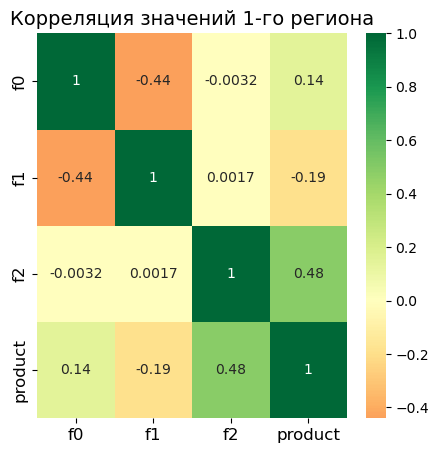

In [72]:
print('Корреляции 1-го региона: ')
display(data_0.corr())

plt.figure(figsize=(5, 5))
sns.heatmap(data_0.corr(),
            xticklabels=data_0.corr().columns,
            yticklabels=data_0.corr().columns,
            cmap='RdYlGn',
            center=0,
            annot=True)

plt.title('Корреляция значений 1-го региона', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Корреляции 2-го региона: 


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


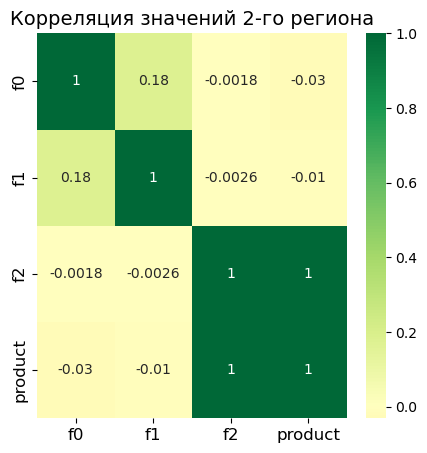

In [73]:
print('Корреляции 2-го региона: ')
display(data_1.corr())

plt.figure(figsize=(5, 5))
sns.heatmap(data_1.corr(),
            xticklabels=data_1.corr().columns,
            yticklabels=data_1.corr().columns,
            cmap='RdYlGn',
            center=0,
            annot=True)

plt.title('Корреляция значений 2-го региона', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Корреляции 3-го региона: 


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


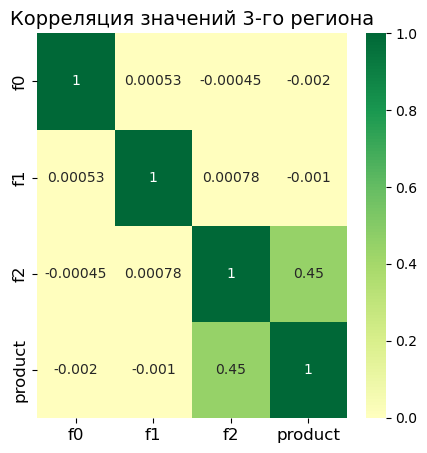

In [74]:
print('Корреляции 3-го региона: ')
display(data_2.corr())

plt.figure(figsize=(5, 5))
sns.heatmap(data_2.corr(),
            xticklabels=data_2.corr().columns,
            yticklabels=data_2.corr().columns,
            cmap='RdYlGn',
            center=0,
            annot=True)

plt.title('Корреляция значений 3-го региона', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Стоит отметить, что на графике корреляции видна сильная зависимость целевого признака `f2` и `product` .

## Обучение и проверка модели

Необходимо подготовить данные для обучения модели, разделив данные на тренировочную и валидационную выборки в соотношении 4:1

In [75]:
data_0 = data_0.drop('id', axis=1)
data_1 = data_1.drop('id', axis=1)
data_2 = data_2.drop('id', axis=1)

In [76]:
data_0.head(), data_1.head(), data_2.head()


(         f0        f1        f2     product
 0  0.705745 -0.497823  1.221170  105.280062
 1  1.334711 -0.340164  4.365080   73.037750
 2  1.022732  0.151990  1.419926   85.265647
 3 -0.032172  0.139033  2.978566  168.620776
 4  1.988431  0.155413  4.751769  154.036647,
           f0         f1        f2     product
 0 -15.001348  -8.276000 -0.005876    3.179103
 1  14.272088  -3.475083  0.999183   26.953261
 2   6.263187  -5.948386  5.001160  134.766305
 3 -13.081196 -11.506057  4.999415  137.945408
 4  12.702195  -8.147433  5.004363  134.766305,
          f0        f1        f2     product
 0 -1.146987  0.963328 -0.828965   27.758673
 1  0.262778  0.269839 -2.530187   56.069697
 2  0.194587  0.289035 -5.586433   62.871910
 3  2.236060 -0.553760  0.930038  114.572842
 4 -0.515993  1.716266  5.899011  149.600746)

В данных видны величины разных количеств, следует рассмотреть через призму .describe

In [77]:
data_0.describe(), data_1.describe(), data_2.describe()

(                  f0             f1             f2        product
 count  100000.000000  100000.000000  100000.000000  100000.000000
 mean        0.500419       0.250143       2.502647      92.500000
 std         0.871832       0.504433       3.248248      44.288691
 min        -1.408605      -0.848218     -12.088328       0.000000
 25%        -0.072580      -0.200881       0.287748      56.497507
 50%         0.502360       0.250252       2.515969      91.849972
 75%         1.073581       0.700646       4.715088     128.564089
 max         2.362331       1.343769      16.003790     185.364347,
                   f0             f1             f2        product
 count  100000.000000  100000.000000  100000.000000  100000.000000
 mean        1.141296      -4.796579       2.494541      68.825000
 std         8.965932       5.119872       1.703572      45.944423
 min       -31.609576     -26.358598      -0.018144       0.000000
 25%        -6.298551      -8.267985       1.000021      26.9

### Разделение данные на тренировочную и валидационные выборки

In [84]:
# Обозначение целевого признака в выборках

target_0 = data_0['product']
features_0 = data_0.drop(['product'], axis=1)

target_1 = data_1['product']
features_1 = data_1.drop(['product'], axis=1)

target_2 = data_2['product']
features_2 = data_2.drop(['product'], axis=1)

#### Разделение данных 1-го региона на выборки

In [85]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(
    features_0, target_0, test_size=0.25, random_state=112263)

print(f'Размер обучающей выборки: {features_train_0.shape}')
print(f'Размер валидационной выборки: {features_valid_0.shape}')

Размер обучающей выборки: (75000, 3)
Размер валидационной выборки: (25000, 3)


In [86]:
# StandardScaler данных первого региона

numeric = ['f0', 'f1', 'f2']
scaler_0 = StandardScaler()
scaler_0.fit(features_train_0[numeric])
features_train_0[numeric] = scaler_0.transform(features_train_0[numeric])
features_valid_0[numeric] = scaler_0.transform(features_valid_0[numeric])

print(features_train_0.head())
print(features_valid_0.head())

             f0        f1        f2
46195  1.055228 -1.411454  0.296985
25047  1.665126  0.376133  0.048661
72590  0.530919 -1.259375 -1.031486
52365  0.037220  1.312015 -0.350315
49975  0.030287  1.517056  0.086117
             f0        f1        f2
19109  0.923299 -1.581602  0.421151
50437  1.250035 -0.879698 -0.115610
63702 -0.146717  1.290690 -1.144492
43926  1.722898 -0.105218  0.183141
64906  0.287500  0.011847  1.509020


#### Разделение данных 2-го региона на выборки

In [87]:
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(
    features_1, target_1, test_size=0.25, random_state=112263)

print(f'Размер обучающей выборки: {features_train_1.shape}')
print(f'Размер валидационной выборки: {features_valid_1.shape}')

Размер обучающей выборки: (75000, 3)
Размер валидационной выборки: (25000, 3)


In [88]:
# StandardScaler данных второго региона

scaler_1 = StandardScaler()
scaler_1.fit(features_train_1[numeric])
features_train_1[numeric] = scaler_1.transform(features_train_1[numeric])
features_valid_1[numeric] = scaler_1.transform(features_valid_1[numeric])

print(features_train_1.head())
print(features_valid_1.head())

             f0        f1        f2
46195 -1.064824 -1.396606 -0.877309
25047  0.051490 -1.191646  0.291261
72590  0.823502 -1.079048  0.295679
52365 -0.503993 -1.950349  0.298783
49975  0.511618 -0.499494 -1.465044
             f0        f1        f2
19109  0.836896 -1.379857 -1.462314
50437  0.819426  2.206897  1.467563
63702 -1.208456  0.197830  0.298090
43926  0.111555  0.874181  1.465443
64906  1.352866 -0.587236 -0.294792


#### Разделение данных 3-го региона на выборки

In [89]:
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(
    features_2, target_2, test_size=0.25, random_state=112263)

print(f'Размер обучающей выборки: {features_train_0.shape}')
print(f'Размер валидационной выборки: {features_valid_0.shape}')

Размер обучающей выборки: (75000, 3)
Размер валидационной выборки: (25000, 3)


In [90]:
# StandardScaler данных второго региона

scaler_2 = StandardScaler()
scaler_2.fit(features_train_2[numeric])
features_train_2[numeric] = scaler_2.transform(features_train_2[numeric])
features_valid_2[numeric] = scaler_2.transform(features_valid_2[numeric])

print(features_train_2.head())
print(features_valid_2.head())

             f0        f1        f2
46195 -0.865644  0.194286 -0.020176
25047  1.234964  0.455858  0.994995
72590 -0.940211 -0.264710 -0.484400
52365 -0.661425  1.684378 -0.468099
49975  0.211364 -1.576459 -1.196953
             f0        f1        f2
19109 -1.080343 -0.456520 -0.051314
50437  0.292995 -1.002271 -0.335452
63702 -0.496079  1.452022 -0.244353
43926 -1.542887  0.905610 -2.303038
64906  0.428048  0.681811 -0.610899


### Обучение модели и рассчет предсказаний

Для обучения была выбрана модель Linear Regression, поскольку не требует дополнительного поиска гиперпараметров, что во всяком случае не указано в ТЗ 

In [91]:
model_lr_0=LinearRegression()
model_lr_0.fit(features_train_0,target_train_0)
predict_lr_0=model_lr_0.predict(features_valid_0)

rmse_lr_0 = mse(target_valid_0, predict_lr_0)**0.5
r2_lr_0 = r2_score(target_valid_0, predict_lr_0)

print('Результаты модели для первого региона: ')
print(f'RMSE: {rmse_lr_0.round(2)}')
# print(f'R2: {r2_lr_0.round(2)}')

Результаты модели для первого региона: 
RMSE: 37.65


In [92]:
model_lr_1=LinearRegression()
model_lr_1.fit(features_train_1,target_train_1)
predict_lr_1=model_lr_1.predict(features_valid_1)

rmse_lr_1 = mse(target_valid_1, predict_lr_1)**0.5
r2_lr_1 = r2_score(target_valid_1, predict_lr_1)

print('Результаты модели для второго региона: ')
print(f'RMSE: {rmse_lr_1.round(2)}')


Результаты модели для второго региона: 
RMSE: 0.9


In [93]:
model_lr_2=LinearRegression()
model_lr_2.fit(features_train_2,target_train_2)
predict_lr_2=model_lr_2.predict(features_valid_2)

rmse_lr_2 = mse(target_valid_2, predict_lr_2)**0.5
r2_lr_2 = r2_score(target_valid_2, predict_lr_2)

print('Результаты модели для третьего региона: ')
print(f'RMSE: {rmse_lr_2.round(2)}')


Результаты модели для третьего региона: 
RMSE: 40.15


In [94]:
print(f'Средний запас сырья в 1 регионе: {predict_lr_0.mean().round(2)}, RMSE: {rmse_lr_0.round(2)}')
print(f'Средний запас сырья в 2 регионе: {predict_lr_1.mean().round(2)}, RMSE: {rmse_lr_1.round(2)}')
print(f'Средний запас сырья в 3 регионе: {predict_lr_2.mean().round(2)}, RMSE: {rmse_lr_2.round(2)}')

Средний запас сырья в 1 регионе: 92.49, RMSE: 37.65
Средний запас сырья в 2 регионе: 68.88, RMSE: 0.9
Средний запас сырья в 3 регионе: 95.17, RMSE: 40.15


Модели обучены, рассчитаные средние объемы запаса сырья в регионах, рассчитаны значения вероятности ошибки RMSE. Стоит отметить что значение RMSE во втором регионе значительно отличается от остальных

## Подготовка к расчёту прибыли

Все ключевые значения для расчётов сохраняем в отдельных переменных

In [95]:
budget = 10000000  # Бюджет на разработку скважин в регионе, тыс. руб
income_one_product = 450  # Доход единицы продукта, тыс. руб
target_proba_loss = 0.025  # Вероятность убытка

product_mean_0 = data_0['product'].mean()
product_mean_1 = data_1['product'].mean()
product_mean_2 = data_2['product'].mean()

In [96]:
print('Cредний запас в 1 регионе: {:.2f} млн. баррелей'.format(product_mean_0))
print('Cредний запас в 2 регионе: {:.2f} млн. баррелей'.format(product_mean_1))
print('Cредний запас в 3 регионе: {:.2f} млн. баррелей'.format(product_mean_2))

Cредний запас в 1 регионе: 92.50 млн. баррелей
Cредний запас в 2 регионе: 68.83 млн. баррелей
Cредний запас в 3 регионе: 95.00 млн. баррелей


In [97]:
budget_per_point = (budget / 200)
print(f'Бюджет на разработку одной скважины: {budget_per_point/1000} млн.руб')

Бюджет на разработку одной скважины: 50.0 млн.руб


Рассчитываем достаточный объём сырья для безубыточной разработки новой скважины

In [98]:
product_volume = budget_per_point / income_one_product
print('Минимальный объём скважины для безубыточной разработки: {:.2f} тыс. баррелей'
    .format(product_volume))

Минимальный объём скважины для безубыточной разработки: 111.11 тыс. баррелей


In [99]:
print('Разница объёма сырья для безубыточной разработки скважины и среднего значения: {:.2f} тыс.баррелей'
    .format(product_volume - product_mean_0))
print('В процентах это: {:.2%} '.format(product_mean_0 / product_volume - 1))

Разница объёма сырья для безубыточной разработки скважины и среднего значения: 18.61 тыс.баррелей
В процентах это: -16.75% 


### Сравним полученный объём сырья со средним запасом в каждом регионе

#### Рассчет для первого региона 

In [100]:
data_0['profit'] = (data_0['product'] * (income_one_product)).round(2) # profit - Выручка, размерность: тыс. руб
data_0.head()

,f0,f1,f2,product,profit
0,0.705745,-0.497823,1.221170,105.280062,47376.03
1,1.334711,-0.340164,4.365080,73.037750,32866.99
2,1.022732,0.151990,1.419926,85.265647,38369.54
3,-0.032172,0.139033,2.978566,168.620776,75879.35
4,1.988431,0.155413,4.751769,154.036647,69316.49


Рассчитаем показатели окупаемости (ROI) скважин

In [101]:
data_0['roi_%'] = ((data_0['profit'] - budget_per_point) / budget_per_point * 100).round(2)
data_0.head()

,f0,f1,f2,product,profit,roi_%
0,0.705745,-0.497823,1.221170,105.280062,47376.03,-5.25
1,1.334711,-0.340164,4.365080,73.037750,32866.99,-34.27
2,1.022732,0.151990,1.419926,85.265647,38369.54,-23.26
3,-0.032172,0.139033,2.978566,168.620776,75879.35,51.76
4,1.988431,0.155413,4.751769,154.036647,69316.49,38.63


In [102]:
loss_volume_0 = product_volume - product_mean_0
loss_volume_percent_0 = product_mean_0 / product_volume - 1

print(loss_volume_0)
print(loss_volume_percent_0)

18.61111111111137
-0.1675000000000023


Определим значение ROI для каждой скважины по отношению к затратам на разработку

In [103]:
print('Первый регион: ')
print('Разница объёма сырья для безубыточной разработки скважины и среднего значения: {:.2f} тыс.баррелей'
    .format(loss_volume_0))
print('В процентах это: {:.2%} '.format(loss_volume_percent_0))

Первый регион: 
Разница объёма сырья для безубыточной разработки скважины и среднего значения: 18.61 тыс.баррелей
В процентах это: -16.75% 


#### Рассчет для второго региона 

In [104]:

data_1['profit'] = (data_1['product'] * (income_one_product)).round(2)  # profit - Выручка, размерность: тыс.руб
data_1.head()

,f0,f1,f2,product,profit
0,-15.001348,-8.276000,-0.005876,3.179103,1430.60
1,14.272088,-3.475083,0.999183,26.953261,12128.97
2,6.263187,-5.948386,5.001160,134.766305,60644.84
3,-13.081196,-11.506057,4.999415,137.945408,62075.43
4,12.702195,-8.147433,5.004363,134.766305,60644.84


Рассчитаем показатели окупаемости (ROI) скважин

In [105]:

data_1['roi_%'] = ((data_1['profit'] - budget_per_point) / budget_per_point * 100).round(2)
data_1.head()

,f0,f1,f2,product,profit,roi_%
0,-15.001348,-8.276000,-0.005876,3.179103,1430.60,-97.14
1,14.272088,-3.475083,0.999183,26.953261,12128.97,-75.74
2,6.263187,-5.948386,5.001160,134.766305,60644.84,21.29
3,-13.081196,-11.506057,4.999415,137.945408,62075.43,24.15
4,12.702195,-8.147433,5.004363,134.766305,60644.84,21.29


In [106]:
loss_volume_1 = product_volume - product_mean_1
loss_volume_percent_1 = product_mean_1 / product_volume - 1

print(loss_volume_1)
print(loss_volume_percent_1)


42.2861111110855
-0.3805749999997695


In [107]:
print('Второй регион: ')
print('Разница объёма сырья для безубыточной разработки скважины и среднего значения: {:.2f} тыс.баррелей'
    .format(loss_volume_1))
print('В процентах это: {:.2%} '.format(loss_volume_percent_1))

Второй регион: 
Разница объёма сырья для безубыточной разработки скважины и среднего значения: 42.29 тыс.баррелей
В процентах это: -38.06% 


#### Рассчет для третьего региона 

In [108]:

data_2['profit'] = (data_2['product'] * (income_one_product)).round(2)  # profit - Выручка, размерность: тыс.руб
data_2.head()

,f0,f1,f2,product,profit
0,-1.146987,0.963328,-0.828965,27.758673,12491.40
1,0.262778,0.269839,-2.530187,56.069697,25231.36
2,0.194587,0.289035,-5.586433,62.871910,28292.36
3,2.236060,-0.553760,0.930038,114.572842,51557.78
4,-0.515993,1.716266,5.899011,149.600746,67320.34


Рассчитаем показатели окупаемости (ROI) скважин

In [109]:

data_2['roi_%'] = ((data_2['profit'] - budget_per_point) / budget_per_point * 100).round(2)
data_2.head()

,f0,f1,f2,product,profit,roi_%
0,-1.146987,0.963328,-0.828965,27.758673,12491.40,-75.02
1,0.262778,0.269839,-2.530187,56.069697,25231.36,-49.54
2,0.194587,0.289035,-5.586433,62.871910,28292.36,-43.42
3,2.236060,-0.553760,0.930038,114.572842,51557.78,3.12
4,-0.515993,1.716266,5.899011,149.600746,67320.34,34.64


In [110]:
loss_volume_2 = product_volume - product_mean_2
loss_volume_percent_2 = product_mean_2 / product_volume - 1

print(loss_volume_2)
print(loss_volume_percent_2)


16.111111111110702
-0.14499999999999635


In [111]:
print('Первый регион: ')
print('Разница объёма сырья для безубыточной разработки скважины и среднего значения: {:.2f} тыс.баррелей'
    .format(loss_volume_2))
print('В процентах это: {:.2%} '.format(loss_volume_percent_2))

Первый регион: 
Разница объёма сырья для безубыточной разработки скважины и среднего значения: 16.11 тыс.баррелей
В процентах это: -14.50% 


Стоит отметить, что среднее количество запасов сырья по регионам недостаточно для окупаемости разработки, необходимо выбрать скважины с максимальными запасами сырья

### Создание функции для расчёта прибыли по выбранным скважинам и предсказаниям модели

Выберем скважины с максимальными значениями предсказаний

In [112]:
predict_lr_0

array([115.65489045, 100.32452814,  58.48961265, ..., 100.74773902,
       132.06262883,  88.53127877])

In [113]:

predict_sorted_0 = pd.Series(predict_lr_0, index=target_valid_0.index).sort_values(ascending=False)
predict_sorted_1 = pd.Series(predict_lr_1, index=target_valid_1.index).sort_values(ascending=False)
predict_sorted_2 = pd.Series(predict_lr_2, index=target_valid_2.index).sort_values(ascending=False)

selected_top_0 = predict_sorted_0[:200]
selected_top_0


78948    175.586829
43388    175.565207
17908    172.837709
93716    172.353609
42379    170.820965
            ...    
79044    146.975342
55956    146.948194
88079    146.921022
71642    146.917687
48623    146.831554
Length: 200, dtype: float64

Суммируем целевые значения объёма сырья, соответствующее этим предсказаниям

In [114]:
selected_top_0_sum = selected_top_0.sum()

print('Запас сырья в 200 лучших скважинах в сумме составит: {:.2f} тыс. баррелей'
    .format(selected_top_0_sum))

Запас сырья в 200 лучших скважинах в сумме составит: 30725.95 тыс. баррелей


Рассчитаем прибыль для полученного объёма сырья

In [115]:
profit_pred_0 = (selected_top_0_sum * income_one_product) - budget

print('Прибыль от полученного объёма сырья составит: {:.2f} тыс. рублей'
    .format(profit_pred_0))

Прибыль от полученного объёма сырья составит: 3826679.55 тыс. рублей


Создаем функцию для расчёта прибыли

In [116]:
def profit_region_func(predict, target, count):
    predict_sorted = pd.Series(predict, index=target.index).sort_values(ascending=False)
    selected_top = predict_sorted[:count].sum()
    profit_pred=(selected_top*income_one_product)-budget
   
    print('Суммарный запас сырья 200 лучших скважинах составляет: {:.2f} тыс. баррелей'
    .format(selected_top))
    print('Прибыль от полученного объёма сырья составляет: {:.2f} млн. рублей'
    .format(profit_pred/1000))

### Рассчет прибыли для полученного объёма сырья по регионам

**Прибыль для первого региона**

In [117]:
profit_region_func(predict_lr_0, target_valid_0, 200)

Суммарный запас сырья 200 лучших скважинах составляет: 30725.95 тыс. баррелей
Прибыль от полученного объёма сырья составляет: 3826.68 млн. рублей


**Прибыль для второго региона**

In [118]:
profit_region_func(predict_lr_1, target_valid_1, 200)

Суммарный запас сырья 200 лучших скважинах составляет: 27767.08 тыс. баррелей
Прибыль от полученного объёма сырья составляет: 2495.18 млн. рублей


**Прибыль для третьего региона**

In [119]:
profit_region_func(predict_lr_2, target_valid_2, 200)

Суммарный запас сырья 200 лучших скважинах составляет: 29794.29 тыс. баррелей
Прибыль от полученного объёма сырья составляет: 3407.43 млн. рублей


### Вывод по разделу

Был рассчитан минимальный объем сырья для безубыточной разработки скважин.  
Был рассчитан средний объем сырья скважин по каждому региону, однако ввиду недостаточного колличества запасов было принято решение брать в рассчет объекты с максимальным запасов сырья - 200 лучших от каждого региона.  
Была создана функция для рассчета объемов сырья и прибыли по регионам, и по результатам анализа все три региона оказались потенциально прибыльными.  

## Расчёт прибыли и рисков 

Применим технику Bootstrap с 1000 выборок для рассчета распределение прибыли.  
Рассчитаем среднюю прибыль, 95%-й доверительный интервал и риск убытков

In [120]:
def revenue_region_func(predict, target, count):
    predict_sorted = pd.Series(predict).sort_values(ascending=False)
    selected_top = target[predict_sorted.index][:count]
    product = selected_top.sum()
    revenue = product * income_one_product
    return revenue - budget

In [121]:
def bootstrap_1000(target, predict):
    values = []
    count = 0
    state = np.random.RandomState(1984)
    predict_e = pd.Series(predict, index=target.index)

    for i in range(1000):
        target_subsample = target.sample(n=500, replace=True, random_state=state)

        probs_subsample = predict_e[target_subsample.index]
        values.append(revenue_region_func(probs_subsample, target_subsample, 200))
    for i in values:
        if i < 0:
            count = count + 1

    values = pd.Series(values)
    mean = values.mean()
    confidence_interval = st.t.interval(0.95, len(values) - 1, values.mean(), values.sem())

    plt.title('Распределение прибыли')
    values.plot(kind="hist", grid=True, figsize=(6, 4))
    plt.xlabel('Прибыль, тыс. руб')
    plt.ylabel('Количество')
    plt.show()

    low_quantile_95 = values.quantile(0.025)
    high_quantile_95 = values.quantile(0.975)

    print('Средняя прибыль: {:.2f} млн. руб'.format(mean / 1000))
    print('С вероятностью 95% прибыль в регионе составляет от: {:.2f} млн. руб до: {:.2f} млн. руб'
        .format((low_quantile_95 / 1000), (high_quantile_95 / 1000)))
    print('95% доверительный интервал: от {:.2f} млн.руб до {:.2f} млн.руб'.
          format((confidence_interval[0] / 1000), (confidence_interval[1] / 1000)))
    print('Процент вероятности убытка в регионе составляет {:.1%}'.format(count / 1000))

Первый регион


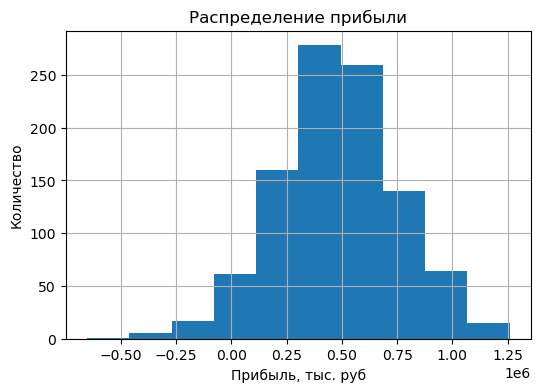

Средняя прибыль: 484.62 млн. руб
С вероятностью 95% прибыль в регионе составляет от: -40.10 млн. руб до: 1017.75 млн. руб
95% доверительный интервал: от 467.84 млн.руб до 501.39 млн.руб
Процент вероятности убытка в регионе составляет 3.3%


In [122]:
print('Первый регион')
bootstrap_1000(target_valid_0, predict_lr_0)

Второй регион


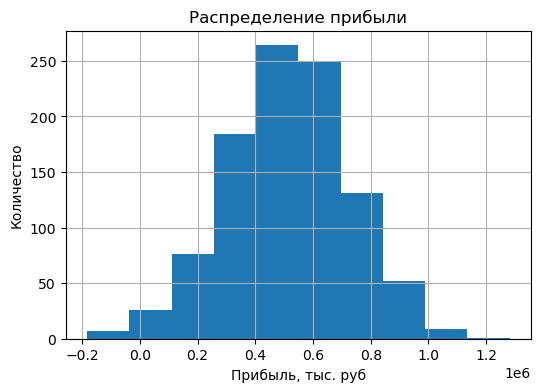

Средняя прибыль: 512.73 млн. руб
С вероятностью 95% прибыль в регионе составляет от: 89.47 млн. руб до: 912.31 млн. руб
95% доверительный интервал: от 499.54 млн.руб до 525.92 млн.руб
Процент вероятности убытка в регионе составляет 0.8%


In [123]:
print('Второй регион')
bootstrap_1000(target_valid_1, predict_lr_1)

Третий регион


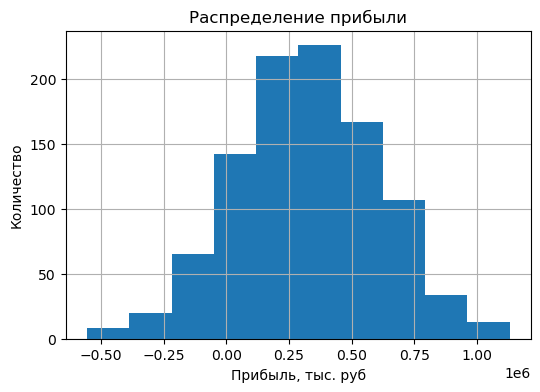

Средняя прибыль: 325.61 млн. руб
С вероятностью 95% прибыль в регионе составляет от: -236.33 млн. руб до: 892.00 млн. руб
95% доверительный интервал: от 307.81 млн.руб до 343.40 млн.руб
Процент вероятности убытка в регионе составляет 12.8%


In [124]:
print('Третий регион')
bootstrap_1000(target_valid_2, predict_lr_2)

### Вывод по разделу

Проведя анализ распределения средних значений прибыли с региоов, самым прибыльным оказался второй регион, средняя прибыль в этом регионе составит 512.73 млн.рублей. Первый и третий регионы не прошли отбор ввиду своего превышающего порога допустимого убытка 2,5%.  
Несмотря на немного уступающий объем запасов сырья в регионе, прогноз доходности скважин во втором регионе выше других.  
Для разработки следует выбрать второй регион, в частности, 200 объектов с наивысшими запасами сырья.  
Анализ данных показал следующие результаты по данному региону: 
- Суммарный запас сырья 200 лучших скважинах составляет: 27767.08 тыс. баррелей  
- Прибыль от полученного объёма сырья составляет: 2495.18 млн. рублей  
- Процент вероятности убытка составляет 0.8%
- Средняя прибыль составляет: 512.73 млн. руб

## Общий вывод

Были проанализированны данные проб нефти в трех регионах.  
В ходе предобработки данных не было выявлено пропусков, отклонений или прочих аномалий.  
Была проведена стандартизация данных, моделью для предсказания была выбрана Linear Regression, так же была применена техника Bootstrap. 

В ходе анализа данных было установлено, что общего объема сырья недостаточно для окупаемости разработки, а по оценкам вероятности риска было принятор решение выбрать 200 объектов в регионе с наибольшими запасами сырья.  
Для лучшего региона с наименьшей оценкой вероятности убытка с такими объектами был рассчитан суммарый запас, прибыль от полученного объема, средняя прибыль. На основе следующих данных для разработки следует выбрать второй регион.
 
Анализ данных по данному региону показал следующие результаты: 
- Суммарный запас сырья 200 лучших скважинах составляет: 27767.08 тыс. баррелей  
- Прибыль от полученного объёма сырья составляет: 2495.18 млн. рублей 
- Процент вероятности убытка составляет 0.8%
- Средняя прибыль составляет: 512.73 млн. руб


Два других региона не прошли отбор ввиду своего превышающего порога допустимого убытка 2,5%, несмотря даже на чуть превышающие запасы сырья в регионах